In [82]:
import numpy as np
import statistics

In [83]:
np.mean([1,2,3])

np.float64(2.0)

In [84]:
data= [1,2,3,4]
new = [3]*len(data)

In [85]:
statistics.stdev(data)

1.2909944487358056

In [86]:
list(map(lambda a, b: (a - b)**2, data, new))

[4, 1, 0, 1]

In [87]:
data = [[1,2],[3,4]]

In [88]:
import numpy as np

In [89]:
np.min(data)

np.int64(1)

In [90]:
import pandas as pd
file_name = 'laptop_prices.csv'
col_name = 'Price_euros'

In [91]:
df = pd.read_csv(file_name)

In [92]:
df.shape

(1275, 23)

In [93]:
df['Price_euros']


0       1339.69
1        898.94
2        575.00
3       2537.45
4       1803.60
         ...   
1270     638.00
1271    1499.00
1272     229.00
1273     764.00
1274     369.00
Name: Price_euros, Length: 1275, dtype: float64

# Create latex code for import the data table from xcel file

In [81]:
import pandas as pd
import numpy as np
import os

def get_file_format(filename):
    # Extract the file extension
    if '.' in filename:
        file_extension = filename.rsplit('.', 1)[1].lower()
        return file_extension
    else:
        return None
    
def dataframe_to_latex(df):
    latex_table = "\\begin{tabular}{" + "|c" * len(df.columns) + "|}\n\\hline\n"
    # Header
    header = " & ".join(df.columns) + " \\\\ \\hline\n"
    latex_table += header
    # Rows
    for index, row in df.iterrows():
        line = " & ".join(map(str, row.tolist())) + " \\\\ \\hline\n"
        latex_table += line
    latex_table += "\\end{tabular}"
    return latex_table

In [82]:
folder = './config_sim_data/wald'
filename = 'result_all_wald.xlsx'
pathfile = os.path.join(folder,filename)
sheet_name = 'waldm1sd2n10000'
format = get_file_format(filename)
if format =='xlsx':
    df = pd.read_excel(pathfile,sheet_name = sheet_name)
df = df.round(2)
df.head()

,method,samp/ch_size,error_l,error_r,error_range,n_learn_l,n_learn_r
0,Online BT,50,-0.02,6.36,6.38,118.31,1.57
1,Online BT,100,-0.02,6.36,6.38,231.36,1.40
2,Online BT,500,-0.02,6.36,6.38,609.00,4.00
3,Min-max online BT,50,-0.04,6.36,6.40,165.67,1.33
4,Min-max online BT,100,-0.04,6.96,7.00,248.58,1.00


In [96]:
latex_code = dataframe_to_latex(df)
filename_latex = 'latex_'+sheet_name+'result_all_wald.txt'
pathfile_latex = os.path.join(folder,filename_latex)
# Write latex_code to the specified file
with open(pathfile_latex, 'w') as file:
    file.write(latex_code)

print(f"LaTeX code has been written to {filename}")

LaTeX code has been written to result_all_wald.xlsx


# Data simulation

In [9]:
import numpy as np
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for F-distribution
dfn = 5    # degrees of freedom for numerator
dfd = 20   # degrees of freedom for denominator
size = 10000  # number of samples

# Generate random samples from F-distribution
f_samples = np.random.f(dfn, dfd, size)

# Print basic statistics
print(f"Mean: {np.mean(f_samples):.3f}")
print(f"Variance: {np.var(f_samples):.3f}")
print(f"First few samples: {f_samples[:5]}")

Mean: 1.115
Variance: 0.682
First few samples: [1.2909638  0.82169965 1.76968188 0.54008759 2.09498857]


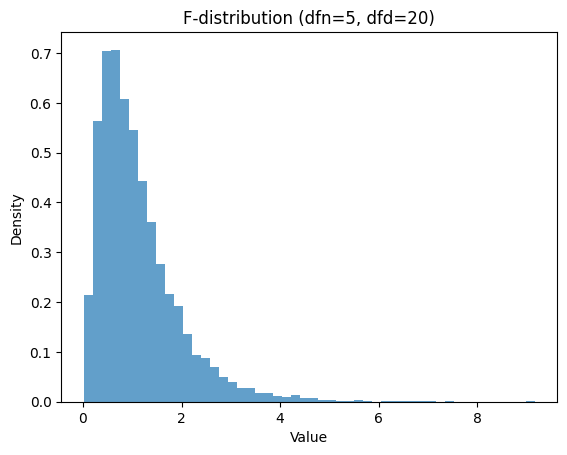

In [10]:
import matplotlib.pyplot as plt

plt.hist(f_samples, bins=50, density=True, alpha=0.7)
plt.title(f'F-distribution (dfn={dfn}, dfd={dfd})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# **Analysing results**

In [15]:
import pickle, os
import pandas as pd
import numpy as np
import openpyxl
from typing import List, Union, Dict
from dataclasses import dataclass, field
import lib_boostrap

In [60]:
import plotly.graph_objects as go
import plotly.io as pio
@dataclass
class Res_boostrap:
    net_name: str = ''
    net:lib_boostrap.booststream = field(default_factory=lib_boostrap.booststream) 
    chunk_size: int=0
    num_chunk: int =0
    exp_l:List[float] = field(default_factory=list)
    exp_r:List[float] = field(default_factory=list)
    exp_range:List[float] =field(default_factory=list)
    nlearnl:List[float] =field(default_factory=list)
    nlearnr:List[float] =field(default_factory=list)
    
    def add_init_params(self, net:lib_boostrap.booststream, cum:bool=False):
        # add net_name attributes.
        self.net = net
        if self.net.online:
            if not self.net.minmax_boost:
                self.net_name = 'online' if not cum else 'online_cum'
            else:
                self.net_name = 'online_mm' if not cum else 'online_mm_cum'
        else:
            self.net_name = 'offline'
        
            
    
    def add_params(self,net:lib_boostrap.booststream):
        self.net = net
        if self.num_chunk == 0:
            self.chunk_size = self.net.chunk_size
        self.num_chunk +=1
        self.exp_l.append(self.net.exp_l)
        self.exp_r.append(self.net.exp_r)
        self.exp_range.append(self.net.range)
        if len(self.nlearnl) == 0:
            self.nlearnl.append(0)
        else: 
            self.nlearnl.append(self.net.nlearn_l[-1])
        if len(self.nlearnr) == 0:
            self.nlearnr.append(0)
        else:    
            self.nlearnr.append(self.net.nlearn_r[-1])



def plot_err_line(error_list:List, name:List,filesave:str, yaxis_title:str = 'range error',xaxis_title:str = 'Chunk No.',color_list:List =  ['brown','blue','green']):
    # Sample data for the line plots
    x = [i for i in range(len(error_list[0]))]  # Common x-axis

    """
    # Data for three different lines
    y1 = exp_l[0][0]     # First line
    y2 = exp_l[0][1]     # Second line
    y3 = exp_l[0][2]     # Third line
    """
    # Create a figure
    fig = go.Figure()
    color = ['brown','blue','green']
    for i in range(len(error_list)):
        fig.add_trace(go.Scatter(x=x, y=error_list[i], mode='lines+markers', name=name[i], line=dict(color=color_list[i])))  
    # Update layout with titles and labels
    fig.update_layout(
        # title='Three Line Plots with Base Value Line',
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        legend_title='Lines',
        template='plotly'
    )
    pio.write_image(fig, filesave+'.png')  
    fig.show()

def plot_nlearn_line(nlearnl:List, name:List, filesave:str,yaxis_title:str = 'numbers of samples for boostraping',xaxis_title:str = 'Chunk No.',color_list:List =  ['brown','blue','green']):
    # Sample data for the line plots
    x = [i for i in range(len(nlearnl[0]))]  # Common x-axis
    # Create a figure
    fig = go.Figure()
   
    for i in range(len(nlearnl)-1):
        fig.add_trace(go.Scatter(x=x, y=nlearnl[i], mode='lines+markers', name=name[i], line=dict(color=color_list[i])))  
    # Update layout with titles and labels
    fig.update_layout(
        # title='Three Line Plots with Base Value Line',
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        legend_title='Lines',
        template='plotly'
    )  
    pio.write_image(fig, filesave+'.png')
    fig.show()
    
    
def plot_minmax_line(exp_l:List, exp_r:List, name_l:List,name_r:List, popminmax:List,filesave:str,yaxis_title:str = 'Value',xaxis_title:str = 'Chunk No.',color_list:List =  ['brown','blue','green']):
    # Sample data for the line plots
    x = [i for i in range(len(exp_l[0]))]  # Common x-axis

    """
    # Data for three different lines
    y1 = exp_l[0][0]     # First line
    y2 = exp_l[0][1]     # Second line
    y3 = exp_l[0][2]     # Third line
    """
    # Create a figure
    fig = go.Figure()
   
    for i in range(len(exp_l)):
        fig.add_trace(go.Scatter(x=x, y=exp_l[i], mode='lines+markers', name=name_l[i], line=dict(color=color_list[i])))  
        fig.add_trace(go.Scatter(x=x, y=exp_r[i], mode='lines+markers', name=name_r[i], line=dict(color=color_list[i])))  
    # Add horizontal line for the base value
    fig.add_trace(go.Scatter(x=[min(x), max(x)], y=[popminmax[0], popminmax[0]], 
                            mode='lines', name=f'min pop: {popminmax[0]:.4f}', 
                            line=dict(color='grey', dash='dash')))
    fig.add_trace(go.Scatter(x=[min(x), max(x)], y=[popminmax[1], popminmax[1]], 
                            mode='lines', name=f'max pop: {popminmax[1]:.4f}', 
                            line=dict(color='grey', dash='dash')))
    # Update layout with titles and labels
    fig.update_layout(
        # title='Three Line Plots with Base Value Line',
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        legend_title='Lines',
        template='plotly'
    )  
    pio.write_image(fig, filesave+'.png')
    fig.show()


def plot_hist(data:List,filesave:str):


    # Generate random data for the histogram
    data = np.array(data)  # 1000 data points from a normal distribution

    # Create a histogram
    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=data,
        nbinsx=100,  # Number of bins
        marker=dict(color='blue', opacity=0.7),  # Style
        name='Data Distribution'
    ))

    # Update layout
    fig.update_layout(
        # title='Histogram of Data',
        xaxis_title='Value',
        yaxis_title='Count',
        template='plotly'
    )
    pio.write_image(fig, filesave+'.png')
    # Show the histogram
    fig.show()

In [61]:
import pandas as pd

In [63]:
"""
# Wiebull
folder_path = './config_sim_data/wiebull/' # folder result.
filename_list = ['wiebullshape1n10000','wiebullshape1n50000','wiebullshape5n10000',
                        'wiebullshape5n50000'] # file names of sample data chunks (.json)

folder_path = './config_sim_data/wald/' # folder result.
filename_list = ['waldm1sd2n10000','waldm1sd05n10000',
                    'waldm3sd2n10000','waldm3sd05n10000',
                    'waldm3sd05n10000']# file names of sample data chunks (.json)
folder_path = './config_sim_data/normal/'
filename_list = ['normalm0sd1n10000','normalm0sd4n10000',
                    'normalm0sd25n50000','normalm0sd100n50000']
"""
folder_path = './config_sim_data/fdist/' # folder result.
filename_list = ['fdistdfn5dfd10n10000','fdistdfn5dfd15n10000','fdistdfn5dfd20n10000']

res_all = []
pop_data = []
for filename in filename_list:
# idx = 1
    file_re = folder_path+filename+'_re.pkl' # file results
    file_pop = folder_path+filename # file name of population data.
# load all instances.
    with open(file_re, 'rb') as file:
        loaded_data = pickle.load(file)
    temp = loaded_data['result_all']    
    res_all.append(temp)    
    pop_data.append(pd.read_pickle(file_pop+'.pkl'))    
    pop_min = np.min(pop_data[-1])
    pop_max = np.max(pop_data[-1])
    pop_range = pop_max - pop_min
    plot_hist(pop_data[-1],filesave=file_pop)

FileNotFoundError: [Errno 2] No such file or directory: './config_sim_data/fdist/fdistdfn5dfd20n10000.pkl'

In [46]:
len(res_all)

3

In [57]:
idx = 2
res = res_all[idx]
ch_size = list(set([res1.chunk_size for res1 in res]))
exp_l = []
exp_r = []
exp_range = []
nlearn = []
name_l = []
name_r = []
for size in ch_size:
    name_l.append(['min_'+res1.net_name+str(size) for res1 in res if res1.chunk_size==size])
    name_r.append(['max_'+res1.net_name+str(size) for res1 in res if res1.chunk_size==size])
    exp_l.append([res1.exp_l for res1 in res if res1.chunk_size==size])
    exp_r.append([res1.exp_r for res1 in res if res1.chunk_size==size])
    exp_range.append([res1.exp_range for res1 in res if res1.chunk_size==size])
    
    nlearn.append([[a+b for a,b in zip(res1.nlearnl,res1.nlearnr)] for res1 in res if res1.chunk_size==size])
    

In [58]:
error_l = []
error_r = []
error_range = []
name = []
for size in ch_size:
    name.append([res1.net_name+str(size) for res1 in res if res1.chunk_size==size])
    error_l.append([list(map(lambda x: pop_min - x, res1.exp_l)) for res1 in res if res1.chunk_size==size])
    error_r.append([list(map(lambda x: pop_max - x, res1.exp_r)) for res1 in res if res1.chunk_size==size])
    error_range.append([list(map(lambda x: pop_range - x, res1.exp_range)) for res1 in res if res1.chunk_size==size])    

In [56]:
popminmax = [pop_min,pop_max]
for idx in range(len(exp_l)):
    plot_minmax_line(exp_l[idx], exp_r[idx], name_l[idx],name_r[idx], popminmax,filesave=file_pop+name[idx][0])
    plot_err_line(error_range[idx], name[idx],filesave = file_pop+name[idx][0]+'error')
    plot_nlearn_line(nlearn[idx], name[idx], filesave=file_pop+name[idx][0]+'_n')

In [56]:

ch_size = list(set([res1.chunk_size for res1 in res]))
error_l = []
error_r = []
error_range = []
name = []
for size in ch_size:
    name.append([res1.net_name+str(size) for res1 in res if res1.chunk_size==size])
    error_l.append([list(map(lambda x: pop_min - x, res1.exp_l)) for res1 in res if res1.chunk_size==size])
    error_r.append([list(map(lambda x: pop_max - x, res1.exp_r)) for res1 in res if res1.chunk_size==size])
    error_range.append([list(map(lambda x: pop_range - x, res1.exp_range)) for res1 in res if res1.chunk_size==size])

In [48]:
vars_dict = {}
id_ch = 1
for i in range(3):
    vars_dict[f'name{i}'] = name[i]
    vars_dict[f'exp_l{i}'] = error_l[i]
    vars_dict[f'exp_r{i}'] = error_r[i]
    vars_dict[f'exp_range{i}'] = error_range[i]